# Análise exploratória dos Microdados do ENADE

## Alunos:
    - Berly Joaquin
    - Leonardo Lopes

## Objetivos

O objetivo deste trabalho é analisar a série histórica do perfil dos participantes que realizaram a prova do ENADE. O foco será nas informações econômicas, como renda e outros fatores econômicos.

## Bibliotecas Utilizadas

Para a análise feita neste trabalho, utilizamos as bibliotecas **Pandas**, **Numpy** e **Matplotlib** da linguagem Python

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess

from sklearn.tree import DecisionTreeClassifier, export_graphviz

## Preparando os dados

Na etapa da preparação dos dados, foi necessário tratar as informações obtidas nas bases de dados fornecidas.

### Tipos de Informações

* **Ano**: representa ano em que o exame foi realizado e está disponível na base de dados na coluna `nu_ano` sem maior necessidade de tratamentos de dados;
* **Idade**: análoga à informação de ano, está disponível na base de dados de forma amigável na coluna `nu_idade` e não foi necessário tratar estes dados;
* **Renda**: representa a renda da família em número de salários mínimos (independente do ano do exame), foi o tipo de dado que apresentou maiores dificuldades no seu tratamento, uma vez que a informação aparece com diferetes nomes de colunas na base de dados original e seus valores categórios não nos trazem grandes informações de forma imediata. Para tal, transformamos o a informação categórica em dados numéricos (a categoria foi mapeada para seu valor médio)

In [25]:
dict_select_bolsa_13_14={ 'a': True,
                          'b': True,
                          'c': True,
                          'd': True,
                          'e': True,
                          'g': True,
                          'h': True,
                          'i': True,
                          'j': True,
                          'k': True,
}


In [26]:
def clean_data(dataframe, renda, bolsa, dict_renda=None):
    new_dataframe = pd.DataFrame(columns=['ano', 'idade'])
    new_dataframe['ano'] = dataframe['nu_ano']
    new_dataframe['idade'] = dataframe['nu_idade']
    new_dataframe['curso'] = dataframe['co_grupo']
    new_dataframe['bolsa'] = dataframe[bolsa].str.lower()
    
    if dict_renda is None:
        dict_renda = { 'a': 1.5, 'b': 2.25, 'c': 3.75, 'd': 5.25, 'e': 8.0, 'f': 15.0, 'g': 30.0 }
    
    r = dataframe[renda].str.lower()
    
    new_dataframe['renda'] = r.map(dict_renda)
    def m(item):
        return round(item/20)
    new_dataframe['nota'] = dataframe['nt_ger'].map(m)

    def f(i):
        return dict_select_bolsa_13_14.get(df["bolsa"][i], False)

    return new_dataframe.select(f)

### Obtendo os dados

Os dados da base de dados foram obtidos a partir do arquivo .csv de cada ano

In [27]:
def is_number(s):
    try:
        f = float(s)
        if f >= 0:
            return True
        return False
    except ValueError:
        return False


In [28]:
def select_clause(df):
    def f(i):
        if df["co_grupo"][i] == 4004 and is_number(df["nt_ger"][i]):
            return True
        else:
            return False
    return f

In [29]:
# dict_renda_2011 = { 'b': 1.5, 'c': 2.25, 'd': 3.75, 'e': 5.25, 'f': 8.0, 'g': 15.0, 'h': 30.0 }

# df10 = clean_data(pd.read_csv('microdados_enade_2010.csv', encoding='latin1', delimiter=';'), 'QE_I5', 'QE_I10')
# df11 = clean_data(pd.read_csv('microdados_enade_2011.csv', encoding='latin1', delimiter=';'), 'co_rs_s5','co_rs_s10', dict_renda_2011)
# df12 = clean_data(pd.read_csv('microdados_enade_2012.csv' ,encoding='latin1', delimiter=';'), 'qe_i5', 'qe_i10')
# df13 = clean_data(pd.read_csv('microdados_enade_2013.csv', delimiter=';'), 'co_rs_s7', 'co_rs_s10' )
data = pd.read_csv('microdados_enade_2014.csv', delimiter=';', low_memory=False)
df14 = clean_data(data.select(select_clause(data)),  'qe_i8', 'qe_i11')
df = df14

# dfs = [df10, df11, df12, df13, df14]

In [30]:
# df = pd.DataFrame()

# df = df.append(dfs)
pd.options.display.float_format = '{:.2f}'.format

df.describe()

,ano,idade,curso,renda,nota
count,8174.00,8174.00,8174.00,8174.00,8174.00
mean,2014.00,25.28,4004.00,6.55,2.23
std,0.00,4.39,0.00,5.25,0.74
min,2014.00,18.00,4004.00,1.50,0.00
25%,2014.00,22.00,4004.00,2.25,2.00
50%,2014.00,24.00,4004.00,5.25,2.00
75%,2014.00,27.00,4004.00,8.00,3.00
max,2014.00,65.00,4004.00,30.00,5.00


In [31]:
df.bolsa.unique()

array(['a', 'h', 'i', 'c', 'b', 'j', 'e', 'k', 'd', 'g'], dtype=object)

In [32]:
atributos = ["idade", "renda", "nota"]
categoria = df["bolsa"]
dataframe = df[atributos]
dt = DecisionTreeClassifier(min_samples_split=20, random_state=99)
dt.fit(dataframe, categoria)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=99, splitter='best')

In [59]:
# http://chrisstrelioff.ws/sandbox/2015/06/08/decision_trees_in_python_with_scikit_learn_and_pandas.html
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")
%matplotlib inline
visualize_tree(dt, atributos)


from IPython.display import Image
dot_data = export_graphviz(dt, out_file=None, 
                         feature_names=atributos,  
                         class_names=atributos,  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

IndexError: list index out of range

### Visualizando a Distribuição dos Dados

Para melhorar a visualização dos dados, montamos um bloxplot com os dados da renda dos candidatos do ENADE.

Analisando os últimos 5 anos da base, foi possível notar que no ano de 2012 houve um pico nos dados de renda e seus valores estao acima dos dados dos outros anos.

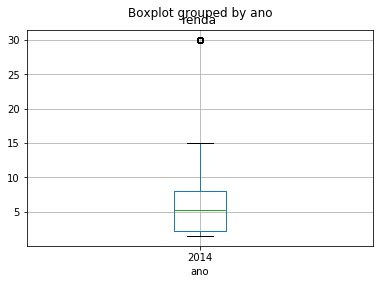

In [13]:
%matplotlib inline
df.boxplot(column='renda', by='ano')

Além disso, montamos um histogrma-para a visualização destes dados de outra forma:

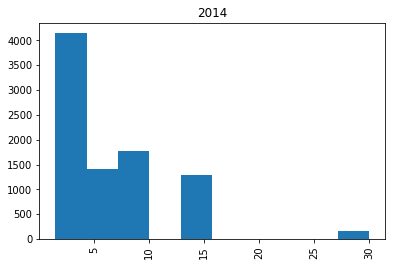

In [14]:
%matplotlib inline
df['renda'].hist(by=df['ano'])

Agora vamos a distribuição univariada do dado tipo de bolsa, ao ser um dado categórico faremos uma análise de barra de caracteres.
Primeiro iremos definir os dicionários que utilizaremos para esta análise

In [8]:
#dict_bolsa_10_11_12  Esta variavel servirá como dicionario para os anos 2010, 2011 e 2012   
dict_bolsa_10_11_12 = {'a': 'ProUni Integral', 
                       'b': 'ProUni Parcial', 
                       'c': 'FIES', 
                       'd':'ProUni Parcial e FIES',
                       'e':'Otra do estado', 
                       'f':'Ofrecida pela própia instituição de ensino', 
                       'g': 'Empresa, ONG, etc', 
                       'h':'Financiamiento pela própia institução de ensino', 
                       'i':'Financiamento pelo banco privado, etc', 
                       'j':'Mais de um dos tipos de bolsa ou financiamento citados'}

# dict_bolsa_13_14 Esta variavel servirá como dicionario para os anos 2013 e 2014

dict_bolsa_13_14={'a': 'Nenhum, pois meu curso é gratuito',
                  'b':'Nenhum, embora meu curso não seja gratuito',
                  'c':'ProUni integral', 
                  'd':'ProUni parcial, apenas',
                  'e':'FIES, apenas', 'f': 'ProUni Parcial e FIES',
                  'g':'Bolsa oferecida por governo estadual, distrital ou municipal', 
                  'h' :'Bolsa oferecida pela própria instituição', 
                  'i':'Bolsa oferecida por outra entidade (empresa, ONG, outra)', 
                  'j' : 'Financiamento oferecido pela própria instituição',
                  'k': 'Financiamento bancário'}


Uma vez criada as variáveis passaremos a mapear cada DataFrame.

In [10]:
# Mapeando o ano 2010
"""
p10=df10['bolsa'].str.lower()
df10['bolsa']=p10.map(dict_bolsa_10_11_12)

# Mapeando o ano 2011
p11=df11['bolsa'].str.lower()
df11['bolsa']=p11.map(dict_bolsa_10_11_12)

# Mapeando o ano 2012
p12=df12['bolsa'].str.lower()
df12['bolsa']=p12.map(dict_bolsa_10_11_12)

# Mapeando o ano 2013
p13=df13['bolsa'].str.lower()
df13['bolsa']=p13.map(dict_bolsa_13_14)
"""
# Mapeando o ano 2014
p14=df14['bolsa'].str.lower()
df14['bolsa']=p14.map(dict_bolsa_13_14)




Agora vamos plotar um grafico de barras de caracter para observar a distribuição do tipo de carteira pela cada ano.

In [ ]:

#------------------------------------- ANO 2010 --------------------------------------------------

df10_tot=df10['bolsa'].value_counts(ascending=True)
df10_tot


In [ ]:
df10_tot.plot.barh()

In [ ]:

#------------------------------------------ ANO 2011---------------------------------------------------

df11_tot=df11['bolsa'].value_counts(ascending=True)
df11_tot

In [ ]:
df11_tot.plot.barh()

In [ ]:

#------------------------------------------ ANO 2012---------------------------------------------------

df12_tot=df12['bolsa'].value_counts(ascending=True)
df12_tot


In [ ]:
df12_tot.plot.barh()

In [ ]:

#------------------------------------------ ANO 2013---------------------------------------------------

def13_tot=df13['bolsa'].value_counts(ascending=True)
def13_tot


In [ ]:
def13_tot.plot.barh()

In [11]:

#------------------------------------------ ANO 2014---------------------------------------------------

def14_tot=df14['bolsa'].value_counts(ascending=True)
def14_tot


Financiamento bancário                                            2172
ProUni Parcial e FIES                                             2949
Financiamento oferecido pela própria instituição                  4722
ProUni parcial, apenas                                            6676
Bolsa oferecida por outra entidade (empresa, ONG, outra)          9196
Bolsa oferecida por governo estadual, distrital ou municipal     15785
ProUni integral                                                  19970
Bolsa oferecida pela própria instituição                         31647
FIES, apenas                                                     33658
Nenhum, embora meu curso não seja gratuito                      143964
Nenhum, pois meu curso é gratuito                               147404
Name: bolsa, dtype: int64

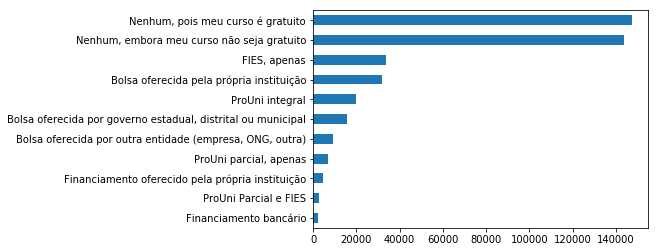

In [12]:
def14_tot.plot.barh()

### Análise Bivariada

Agora vamos fazer uma análise Bivariada a nível descritivo e visual entre as variáveis renda e tipo de bolsa.

In [ ]:

#------------------------------------------ ANO 2010---------------------------------------------------

bi10=pd.crosstab(df10['bolsa'], df10['renda'])
bi10

In [ ]:
bi10.plot.barh(stacked=True, width=0.7, grid=False)

In [ ]:

#------------------------------------------ ANO 2011---------------------------------------------------

bi11=pd.crosstab(df11['bolsa'], df11['renda'])
bi11

In [ ]:
bi11.plot.barh(stacked=True, width=0.7, grid=False)

In [ ]:

#------------------------------------------ ANO 2012---------------------------------------------------

bi12=pd.crosstab(df12['bolsa'], df12['renda'])
bi12


In [ ]:
bi12.plot.barh(stacked=True, width=0.7, grid=False)

In [ ]:

#------------------------------------------ ANO 2013---------------------------------------------------

bi13=pd.crosstab(df13['bolsa'], df13['renda'])
bi13


In [ ]:
bi13.plot.barh(stacked=True, width=0.7, grid=False)

In [ ]:

#------------------------------------------ ANO 2014---------------------------------------------------

bi14=pd.crosstab(df14['bolsa'], df14['renda'])
bi14


In [ ]:
bi14.plot.barh(stacked=True, width=0.7, grid=False)